# Print classifier result

In [1]:
from time import time
from sklearn.utils.extmath import density
from sklearn import metrics

results = []


# Benchmark classifiers
def benchmark(clf, name):
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    
    joblib.dump(clf, 'models/' + name + '.pkl') 
    
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    feature_names = vectorizer.get_feature_names()

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
        print()
    
    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                        target_names=target_names))


#     print("confusion matrix:")
#     print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    results.append([clf_descr, score, train_time, test_time])

# Prepare training & testing data

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.externals import joblib

categories = None
#remove = ('headers', 'footers', 'quotes')
remove = ()
    
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

target_names = data_train.target_names
joblib.dump(target_names, 'categories.pkl') 

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print()

print("categories: ", target_names)
print()

11314 documents - 22.055MB (training set)
7532 documents - 13.801MB (test set)

categories:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']



# Generate vectorizer

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib

print("Extracting features from the training data using a sparse vectorizer")

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)


joblib.dump(vectorizer, 'vectorizer.pkl')

print("n_samples: %d, n_features: %d" % X_train.shape)
print()


X_test = vectorizer.transform(data_test.data)

print("n_samples: %d, n_features: %d" % X_test.shape)
print()

Extracting features from the training data using a sparse vectorizer
n_samples: 11314, n_features: 129791

n_samples: 7532, n_features: 129791



# Multinomial Naive Bayes
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [4]:
from sklearn.naive_bayes import MultinomialNB
benchmark(MultinomialNB(alpha=.01), 'MultinomialNB')

Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.136s
test time:  0.037s
accuracy:   0.837
dimensionality: 129791
density: 1.000000

classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.83      0.80      0.81       319
           comp.graphics       0.68      0.74      0.71       389
 comp.os.ms-windows.misc       0.77      0.59      0.67       394
comp.sys.ibm.pc.hardware       0.66      0.77      0.71       392
   comp.sys.mac.hardware       0.83      0.84      0.84       385
          comp.windows.x       0.82      0.79      0.81       395
            misc.forsale       0.81      0.79      0.80       390
               rec.autos       0.90      0.91      0.91       396
         rec.motorcycles       0.94      0.96      0.95       398
      rec.sport.baseball       0.96      0.94      0.95       397
        rec.sport.hockey       0.95      0.98      0.96       399
               

# Bernoulli Naive Bayes
BernoulliNB might perform better on some datasets, especially those with shorter documents. 

In [5]:
from sklearn.naive_bayes import BernoulliNB

benchmark(BernoulliNB(alpha=.01), 'BernoulliNB')

Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.156s
test time:  0.124s
accuracy:   0.771
dimensionality: 129791
density: 1.000000

classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.75      0.83      0.79       319
           comp.graphics       0.55      0.74      0.63       389
 comp.os.ms-windows.misc       0.79      0.07      0.13       394
comp.sys.ibm.pc.hardware       0.51      0.76      0.61       392
   comp.sys.mac.hardware       0.66      0.83      0.74       385
          comp.windows.x       0.80      0.71      0.75       395
            misc.forsale       0.56      0.88      0.68       390
               rec.autos       0.87      0.87      0.87       396
         rec.motorcycles       0.90      0.94      0.92       398
      rec.sport.baseball       0.96      0.90      0.93       397
        rec.sport.hockey       0.97      0.92      0.95       399
   

# Linear Support Vector Classification

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))]), 'LinearSVC')

Training: 
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0),
        norm_order=1, prefit=...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
train time: 7.105s
test time:  0.035s
accuracy:   0.842
classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.78      0.78      0.78       319
           comp.graphics       0.74      0.78      0.76       389
 comp.os.ms-windows.misc       0.79      0.78      0.79       394
comp.sys.ibm.pc.hardware       0.72      0.75      0.74       392
   comp.sys.mac.hardware       0.81      0.83      0.82       385
          comp.windows.x       0.86      0.76      0.81       395
            mis

# Make some plots

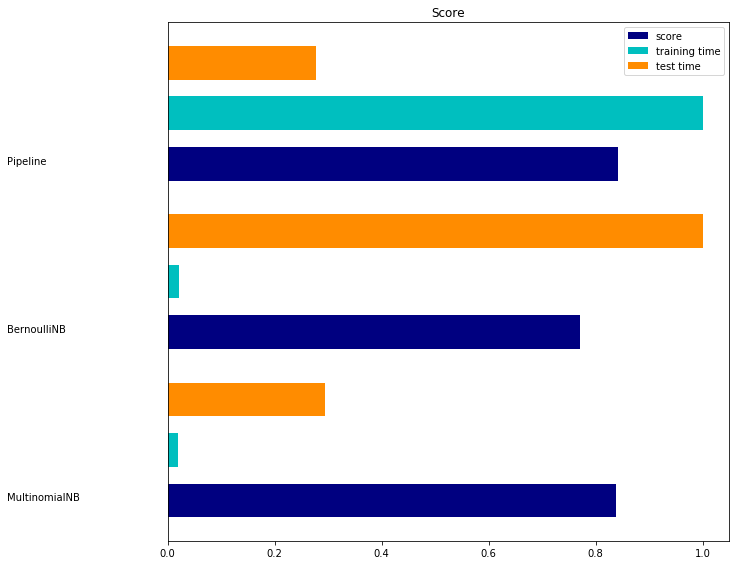

In [7]:
# make some plots

import numpy as np
import matplotlib.pyplot as plt


indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()